## Dataset
Data has been taken from [VOC 2007](http://host.robots.ox.ac.uk/pascal/VOC/voc2007/) dataset.

The twenty object classes that have been selected are:

* Person: person
* Animal: bird, cat, cow, dog, horse, sheep
* Vehicle: aeroplane, bicycle, boat, bus, car, motorbike, train
* Indoor: bottle, chair, dining table, potted plant, sofa, tv/monitor

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import argparse
import xml.etree.ElementTree as ET
import os
import cv2

In [3]:
parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

_StoreAction(option_strings=[], dest='dir', nargs=None, const=None, default='..', type=None, choices=None, help='Annotations.', metavar=None)

In [2]:
sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

In [3]:
classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}

In [4]:
def convert_annotation(in_file):
    '''
    Returns list of string containing bbox coordinates and class id
    Parameter
    ---------
    in_file : str
    	Local path in string 
    
    Returns
    -------
    	list in the form ['xmin', 'ymin', 'xmax', 'ymax', 'cls_id']
    '''
    tree = ET.parse(in_file)
    root = tree.getroot()
    res = ''

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        class_name = obj.find('name').text
        cls_id = classes_num.get(class_name)
        if cls_id == None : 
            continue
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        res += ' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id)
    return res

In [13]:
classes_num.get('a') == None

True

## Algorithm
### Shapes and probabilities
The input is a (448, 448, 3) image and the output is a (7, 7, 30) tensor. The output is based on S x S x (B * 5 +C).

B = 2 in YOLO-v1 and no of classes = 20 => 2 * 5 + 20 = 30.

S X S is the number of grids, B is the number of bounding boxes per grid, C is the number of predictions per grid

The system divides the image into an S x S grid. Each of these grid cells predicts B bounding boxes and confidence scores for these boxes. The confidence score indicates how sure the model is that the box contains an object and also how accurate it thinks the box is that predicts. The confidence score can be calculated using the formula:
$C = Pr(object) * IoU$

$IoU$: Intersection over Union between the predicted box and the ground truth.

If no object exists in a cell, its confidence score should be zero.

<img src ="images/bbox.png" width= "250px"/>

Each grid cell also predicts C conditional class probabilities $Pr(Classi|Object)$.

It only predicts one set of class probabilities per grid cell, regardless of the number of boxes B. During testing, these conditional class probabilities are multiplied by individual box confidence predictions which give class-specific confidence scores for each box. These scores show both the probability of that class and how well the box fits the object.

$Pr(Class i|Object)*Pr(Object)*IoU = Pr(Class i)*IoU$.

The final predictions are encoded as an S x S x (B*5 + C) tensor.

### Intersection Over Union (IoU):
IoU is used to evaluate the object detection algorithm. It is the overlap between the ground truth and the predicted bounding box, i.e it calculates how similar the predicted box is with respect to the ground truth.

![image.png](images/iou.png)

Usually, the threshold for IoU is kept as greater than 0.5. Although many researchers apply a much more stringent threshold like 0.6 or 0.7. If a bounding box has an IoU less than the specified threshold, that bounding box is not taken into consideration.

### Non-Max Suppression (NMS):
The algorithm may find multiple detections of the same object. Non-max suppression is a technique by which the algorithm detects the object only once. Consider an example where the algorithm detected three bounding boxes for the same object. The boxes with respective probabilities are shown in the image below.

![image.png](images/nms1.png)

The probabilities of the boxes are 0.7, 0.9, and 0.6 respectively. To remove the duplicates, we are first going to select the box with the highest probability and output that as a prediction. Then eliminate any bounding box with IoU > 0.5 (or any threshold value) with the predicted output. The result will be:

![image.png](images/nms2.png)

### Network Architecture:
The base model has 24 convolutional layers followed by 2 fully connected layers. It uses 1 x 1 reduction layers followed by a 3 x 3 convolutional layer. Fast YOLO uses a neural network with 9 convolutional layers and fewer filters in those layers. The complete network is shown in the figure.

![image.png](images/yolo_v1_architecture.png)

* The architecture was designed for use in the Pascal VOC dataset, where S = 7, B = 2, and C = 20. This is the reason why final feature maps are 7 x 7, and also the output tensor is of the shape (7 x 7 x (2*5 + 20)). To use this network with a different number of classes or different grid size you might have to tune the layer dimensions.

* The final layer uses a linear activation function. The rest uses a leaky ReLU.

### Limitations Of YOLO:
* Spatial constraints on bounding box predictions as each grid cell only predicts two boxes and can have only one class.
* It is difficult to detect small objects that appear in groups.
* It struggles to generalize objects in new or unusual aspect ratios as the model learns to predict bounding boxes from data itself.

## Create seperate partitions for train, test and val data

In [6]:
if not os.path.isdir("val"):
    os.makedirs("val")
    os.makedirs(os.path.join('val', 'images'))
    os.makedirs(os.path.join('val', 'labels'))
if not os.path.isdir("train"):
    os.makedirs("train")
    os.makedirs(os.path.join('train', 'images'))
    os.makedirs(os.path.join('train', 'labels'))
if not os.path.isdir("test"):
    os.makedirs("test")
    os.makedirs(os.path.join('test', 'images'))
    os.makedirs(os.path.join('test', 'labels'))

In [296]:
import shutil
for set_ in sets :
    print(set_)
    if (set_[1] == 'train') or (set_[1] == 'val'): 
        continue
    full_file_path = os.path.join('VOCdevkit', 
                                f'VOC{set_[0]}', 
                                'ImageSets', 
                                'Main',
                                 f'{set_[1]}.txt')
    
    jpeg_images_folder = os.path.join('VOCdevkit', 
                                      f'VOC{set_[0]}',
                                     'JPEGImages')
    
    annotations_folder = os.path.join('VOCdevkit', 
                                      f'VOC{set_[0]}',
                                     'Annotations')

    with open(full_file_path, 'r') as f :
        for i in f :
            i = i.strip()
            if i == '' : continue
            orig_jpg_path =  os.path.join(jpeg_images_folder, f'{i}.jpg')
            new_jpg_path = os.path.join(f'{set_[1]}', 'images', f'{i}.jpg')
            orig_annot_path = os.path.join(annotations_folder, f'{i}.xml')
            new_annot_path = os.path.join(f'{set_[1]}', 'labels', f'{i}.txt')
            if not os.path.exists(new_jpg_path) :
                shutil.copy(orig_jpg_path, new_jpg_path)
            if not os.path.exists(new_annot_path) :
                with open(new_annot_path, 'w') as f_w :
                    f_w.write(convert_annotation(orig_annot_path))
                    

('2007', 'train')
('2007', 'val')
('2007', 'test')


In [9]:
import albumentations as alb

from albumentations import Rotate, Compose, RandomBrightnessContrast, ImageCompression, HueSaturationValue, HorizontalFlip, RandomCrop, RandomGamma, RGBShift, VerticalFlip, BboxParams, Blur, ZoomBlur, Affine, PadIfNeeded

In [10]:
augmentor = Compose([
            Affine(
                scale=(0.5, 1.5), 
                translate_percent=(0.1, 0.1), 
                p = 0.75, 
                rotate=0.3, 
                shear = (0.5, 1.5)
            ),
            PadIfNeeded(
                border_mode=cv2.BORDER_CONSTANT,
                min_height=448,
                min_width=448
            ),
            RandomCrop(height=448, width=448),
            Blur(blur_limit=10, p=0.1),
            RandomBrightnessContrast(p=0.5),
            ImageCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomGamma(),
            RGBShift(),
            HorizontalFlip()
        ], bbox_params=BboxParams(format = 'pascal_voc', 
                                  label_fields = ['class_labels']))


In [221]:
img = cv2.imread(os.path.join('val', 'images', '009958.jpg'))
img.shape

(333, 500, 3)

In [7]:
def convert_txt(in_file) :
    with open(in_file) as f :
        coords = f.read().split(' ')[1:]  #since first char is blank space
        new_coord = []
        for i in range(len(coords)) :
            res = [int(j) for j in coords[i].split(',')]
            new_coord.append(res)

            new_coord = np.array(new_coord)
            return new_coord

In [ ]:
new_coord = convert_txt(os.path.join('val', 'labels', '009958.txt'))
print(new_coord, new_coord[:, -1],new_coord[:, :-1] ,sep = '\n\n')

In [223]:
augmented = augmentor(class_labels =new_coord[:, -1], image = img, bboxes = new_coord[:, :-1]) 
augmented

{'class_labels': [14, 14, 14, 14, 1],
 'image': array([[[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]],
 
        [[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]],
 
        [[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]],
 
        ...,
 
        [[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]],
 
        [[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]],
 
        [[12,  0,  0],
         [12,  0,  0],
         [12,  0,  0],
         ...,
         [12,  0,  0],
         [12,  0,  0],
         [12,  0,  0]]], dtype=uin

In [224]:
print(augmented.keys(), augmented['bboxes'], augmented['class_labels'], sep = '\n\n')

dict_keys(['class_labels', 'image', 'bboxes'])

[(0.0, 221.95035054599913, 39.31891073338956, 322.49350999577916), (201.78045741390298, 227.1248280136184, 283.4893673337077, 268.9222689647024), (281.2391847792874, 186.6139715571819, 357.74153522603274, 285.4106058582121), (284.587805738158, 192.82164259684976, 375.07303096668693, 237.8306034338055), (244.1970153987622, 234.43907775407646, 371.8257634930136, 336.5431286609433)]

[14, 14, 14, 14, 1]


In [279]:
bboxes = np.array(augmented['bboxes'], dtype = np.int32)
class_labels = np.array(augmented['class_labels'], dtype = np.int32).reshape(-1, 1)
bbox_labels = np.concatenate((bboxes, class_labels), axis = 1)
result = ' '.join([', '.join(map(str, row)) for row in bbox_labels])
result = ' ' + result
# Print the result
print(result)

 0, 221, 39, 322, 14 201, 227, 283, 268, 14 281, 186, 357, 285, 14 284, 192, 375, 237, 14 244, 234, 371, 336, 1


person
person
person
person
bicycle


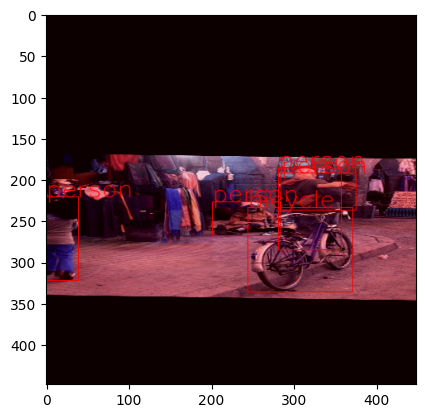

In [225]:
list_classes = list(classes_num)
idx = 0
for xmin, ymin, xmax, ymax in augmented['bboxes']:
    cv2.rectangle(augmented['image'],
                 np.array([xmin, ymin], dtype = np.int32), #pt1
                 np.array([xmax, ymax], dtype = np.int32), #pt2
                 (250, 0, 0), #BGR format
                 1)  #thickness = 2
    
    txt = list_classes[augmented['class_labels'][idx]]
    print(txt)
    cv2.putText(img=augmented['image'],
                   text = txt,
                   org = np.array([xmin, ymin], dtype = np.int32),
                   fontFace = cv2.LINE_AA,
                   fontScale = 1,
                   color = (255, 0, 0),
                   thickness =1,
                    lineType = cv2.LINE_AA
                   )
    idx += 1

plt.imshow(augmented['image'])

In [297]:
for partition in ['train', 'test', 'val'] :
    path1 = os.path.join(partition, 'aug_images')
    if not os.path.isdir(path1):
        os.makedirs(path1)
    path2 = os.path.join(partition, 'aug_labels')
    if not os.path.isdir(path2):
        os.makedirs(path2)

In [291]:
for partition in ['test', 'val'] :
    for image in os.listdir(os.path.join(partition, 'images')) :
        img = cv2.imread(os.path.join(partition, 'images', image))

        label_path = os.path.join(partition, 'labels', f'{image.split(".")[0]}.txt')  #inside f-string do not use single quotes
        coords = convert_txt(label_path)
        #augmentor object is already composed
        try :
            for x in range(100) :  
                augmented = augmentor(class_labels =coords[:, -1], image = img, bboxes = coords[:, :-1]) 
                cv2.imwrite(os.path.join(partition, 'aug_images', f'{image.split(".")[0]}.{x}.jpg') , augmented['image'])

                bboxes = np.array(augmented['bboxes'], dtype = np.int32)
                class_labels = np.array(augmented['class_labels'], dtype = np.int32).reshape(-1, 1)
                bbox_labels = np.concatenate((bboxes, class_labels), axis = 1)
                result = ' '.join([','.join(map(str, row)) for row in bbox_labels])
                result = ' ' + result

                with open(os.path.join(partition, 'aug_labels', f'{image.split(".")[0]}.{x}.txt') , 'w') as f :
                    f.write(result)
        except Exception as e :
            print(e)
                        

axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bou


KeyboardInterrupt



### Using 2 classes

In [6]:
for partition in ['train', 'test', 'val'] :
    path1 = os.path.join(partition, 'images2')
    if not os.path.isdir(path1):
        os.makedirs(path1)
    path2 = os.path.join(partition, 'labels2')
    if not os.path.isdir(path2):
        os.makedirs(path2)

In [21]:
import shutil
for set_ in sets :
    print(set_)
    full_file_path = os.path.join('VOCdevkit', 
                                f'VOC{set_[0]}', 
                                'ImageSets', 
                                'Main',
                                 f'person_{set_[1]}.txt')
    
    jpeg_images_folder = os.path.join('VOCdevkit', 
                                      f'VOC{set_[0]}',
                                     'JPEGImages')
    
    annotations_folder = os.path.join('VOCdevkit', 
                                      f'VOC{set_[0]}',
                                     'Annotations')

    with open(full_file_path, 'r') as f :
        for i in f :
            i = i.strip()
            if i == '' : continue
            if i[7] == '-' : continue
            i = i.split('  ')[0]
            orig_jpg_path =  os.path.join(jpeg_images_folder, f'{i}.jpg')
            new_jpg_path = os.path.join(f'{set_[1]}', 'images2', f'{i}.jpg')
            orig_annot_path = os.path.join(annotations_folder, f'{i}.xml')
            new_annot_path = os.path.join(f'{set_[1]}', 'labels2', f'{i}.txt')
            if not os.path.exists(new_jpg_path) :
                shutil.copy(orig_jpg_path, new_jpg_path)
            if not os.path.exists(new_annot_path) :
                with open(new_annot_path, 'w') as f_w :
                    f_w.write(convert_annotation(orig_annot_path))
                    

('2007', 'train')
('2007', 'val')
('2007', 'test')


In [5]:
for partition in ['train'] :
    path1 = os.path.join(partition, 'aug_images2')
    if not os.path.isdir(path1):
        os.makedirs(path1)
    path2 = os.path.join(partition, 'aug_labels2')
    if not os.path.isdir(path2):
        os.makedirs(path2)

In [11]:
for partition in ['train'] :
    for image in os.listdir(os.path.join(partition, 'images2')) :
        img = cv2.imread(os.path.join(partition, 'images2', image))

        label_path = os.path.join(partition, 'labels2', f'{image.split(".")[0]}.txt')  #inside f-string do not use single quotes
        coords = convert_txt(label_path)
        #augmentor object is already composed
        try :
            for x in range(100) :  
                augmented = augmentor(class_labels =coords[:, -1], image = img, bboxes = coords[:, :-1]) 
                cv2.imwrite(os.path.join(partition, 'aug_images2', f'{image.split(".")[0]}.{x}.jpg') , augmented['image'])

                bboxes = np.array(augmented['bboxes'], dtype = np.int32)
                class_labels = np.array(augmented['class_labels'], dtype = np.int32).reshape(-1, 1)
                bbox_labels = np.concatenate((bboxes, class_labels), axis = 1)
                result = ' '.join([','.join(map(str, row)) for row in bbox_labels])
                result = ' ' + result

                with open(os.path.join(partition, 'aug_labels2', f'{image.split(".")[0]}.{x}.txt') , 'w') as f :
                    f.write(result)
        except Exception as e :
            print(e)
                        

axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bounds for array of dimension 1
axis 1 is out of bou